In [2]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch

In [3]:
cntry_fund_frac_path='../../data/nf_folder/Data/DerivedData/Derived/cntry_fund_frac.csv'
pubs_path="../../data/nf_folder/Data/DerivedData/CleanedRawData/pubs_author_funder.csv"
flag_path='../../data/nf_folder/Data/AdditionalData/country_WoS_ECI_WB_flags.tsv'
rd_path='../../data/nf_folder/Data/DerivedData/CleanedRawData/GDEXPRD_OECD.csv'
cntry_fund_frac_path='../../data/nf_folder/Data/DerivedData/Derived/cntry_fund_frac.csv'

In [4]:
global_funding_path='../../data/nf_folder/Figs/global_funding.pdf'
cntry_funding_path='../../data/nf_folder/Figs/cntry_funding.pdf'

In [4]:
paf = pd.read_csv(pubs_path)
paf['author_country'] = paf['author_country'].apply(literal_eval)
paf['funder_country'] = paf['funder_country'].apply(
    lambda x:literal_eval(x) if pd.notnull(x) else "Not-Funded")
paf.head()

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,author_country,funder_country,discipline,year,rel_citation,citation
0,30507292,[Turkey],[Turkey],77,2009,0.485,6
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9
2,30574691,[Russia],[Russia],83,2009,0.312,4
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3


In [5]:
paf['author_distinct']=paf['author_country'].apply(lambda x:list(set(x)))
paf['funder_distinct']=paf['funder_country'].apply(
    lambda x:list(set(x)) if x!='Not-Funded' else 'Not-Funded')

In [6]:
pubs_df=paf.copy()
pubs_df['coll']=pubs_df['author_distinct'].apply(
    lambda x: 1 if len(x)>1 else 0)

## calculate the funding ratio over year

In [7]:
pubs_df.head(2)

,id,author_country,funder_country,discipline,year,rel_citation,citation,author_distinct,funder_distinct,coll
0,30507292,[Turkey],[Turkey],77,2009,0.485,6,[Turkey],[Turkey],0
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9,"[France, United States]",[United States],1


In [8]:
def num_fd(funders):
    cnt=3
    if funders=='Not-Funded':
        cnt=0
    elif len(funders)<3 and "EU" not in funders:
        cnt=len(funders)
    return cnt
pubs_df['num_fd']=pubs_df.apply(lambda x: num_fd(x.funder_distinct),axis=1)

In [9]:
pubs_df.head()

,id,author_country,funder_country,discipline,year,rel_citation,citation,author_distinct,funder_distinct,coll,num_fd
0,30507292,[Turkey],[Turkey],77,2009,0.485,6,[Turkey],[Turkey],0,1
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9,"[France, United States]",[United States],1,1
2,30574691,[Russia],[Russia],83,2009,0.312,4,[Russia],[Russia],0,1
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1,[Spain],[Spain],0,1
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3,"[Germany, Spain]",[Spain],1,1


In [10]:
collcnt=pubs_df.groupby(['year','coll']).size().reset_index(name='collcnt')
collcnt=collcnt.replace(to_replace={'coll':{0:'dome',1:'intcol'}})
collcnt = collcnt.pivot(index='year',columns='coll',values='collcnt')
collcnt = collcnt.div(collcnt.sum(axis=1), axis=0)
collcnt = collcnt.reset_index().melt(id_vars='year',var_name='type', value_name='value')
collcnt.head()

,year,type,value
0,2009,dome,0.788537
1,2010,dome,0.780102
2,2011,dome,0.774328
3,2012,dome,0.769506
4,2013,dome,0.761927


In [11]:
typedict={1:'Single',0:'Not-Funded',2:'Cofund',3:'Cofund'}
pubs_df['ftype'] = pubs_df['num_fd'].map(typedict)
fdtype = pubs_df.groupby(['year','ftype']).size().reset_index(name='count')
fdtype = fdtype.pivot(index='year',columns='ftype',values='count')
fdtype = fdtype.div(fdtype.sum(axis=1), axis=0)
fdtype = fdtype.reset_index().melt(id_vars='year',var_name='type', value_name='value')
fdtype.head()

,year,type,value
0,2009,Cofund,0.076454
1,2010,Cofund,0.099136
2,2011,Cofund,0.109834
3,2012,Cofund,0.111075
4,2013,Cofund,0.110665


In [12]:
#calculate the proportion of publications that are funded
funded=fdtype[fdtype.type=='Not-Funded']
funded['value']=1-funded['value']
funded['type']='Funded'
fdtype = pd.concat([fdtype,funded])

<ipython-input-12-3f2010b0510e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded['value']=1-funded['value']
<ipython-input-12-3f2010b0510e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded['type']='Funded'


In [13]:
colldata = pubs_df[pubs_df.coll==1]
colldata = colldata.groupby(['year','ftype']).size().reset_index(name='fdcnt')
colldata = colldata.pivot(index='year',columns='ftype',values='fdcnt')
colldata = colldata.div(colldata.sum(axis=1), axis=0)
colldata = colldata.reset_index().melt(id_vars='year',var_name='ftype', value_name='value')
colldata.head()

,year,ftype,value
0,2009,Cofund,0.232649
1,2010,Cofund,0.290164
2,2011,Cofund,0.314389
3,2012,Cofund,0.313172
4,2013,Cofund,0.306208


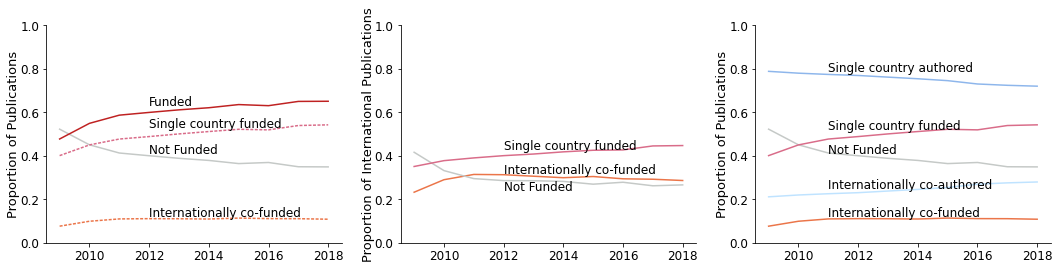

In [17]:
fig, ax=plt.subplots(nrows=1,ncols=3,figsize=(18,4))
ax0=ax[0]
ax1=ax[1]
ax2=ax[2]
sns.lineplot(x='year',y='value',hue='type',
             palette={'Cofund':'#EB7549','Single':'#D96C89','Not-Funded':'#C5C9C7','Funded':'#BF2121'},
             data=fdtype,legend=False,style='type',dashes={'Cofund':(2,1),'Single':(2,1),'Not-Funded':'','Funded':''},
             ax=ax0)

ax0.set_xticks(np.arange(2010,2019,2))
ax0.set_xlabel("")
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.set_ylabel("Proportion of Publications",fontsize=13,labelpad=0)
ax0.text(2012,0.53,s="Single country funded",fontsize=12)
ax0.text(2012,0.41,s="Not Funded",fontsize=12)
ax0.text(2012,0.12,s="Internationally co-funded",fontsize=12)
ax0.text(2012,0.63,s="Funded",fontsize=12)
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_ylim(0,1)
#ax0.set_yticks(np.arange(0,9,1)/10)

sns.lineplot(x='year',y='value',hue='ftype',
             palette={'Cofund':'#EB7549','Single':'#D96C89','Not-Funded':'#C5C9C7'},
             data=colldata,legend=False,ax=ax1)
ax1.set_xticks(np.arange(2010,2019,2))
ax1.set_xlabel("")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel("Proportion of International Publications",fontsize=13,labelpad=0)
ax1.text(2012,0.43,s="Single country funded",fontsize=12)
ax1.text(2012,0.24,s="Not Funded",fontsize=12)
ax1.text(2012,0.32,s="Internationally co-funded",fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim(0,1)
#ax1.set_yticks(np.arange(0,5,1)/10)

sns.lineplot(x='year',y='value',hue='type',
             palette={'dome':'#1E6FD9','intcol':'#81C8FF'},
             data=collcnt,legend=False,alpha=0.5,ax=ax2)
sns.lineplot(x='year',y='value',hue='type',
             palette={'Cofund':'#EB7549','Single':'#D96C89','Not-Funded':'#C5C9C7'},
             data=fdtype[fdtype.type!='Funded'],legend=False,ax=ax2)
ax2.set_xticks(np.arange(2010,2019,2))
ax2.set_xlabel("")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_ylabel("Proportion of Publications",fontsize=13,labelpad=0)
ax2.text(2011,0.52,s="Single country funded",fontsize=12)
ax2.text(2011,0.41,s="Not Funded",fontsize=12)
ax2.text(2011,0.12,s="Internationally co-funded",fontsize=12)
ax2.text(2011,0.79,s="Single country authored",fontsize=12)
ax2.text(2011,0.25,s="Internationally co-authored",fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylim(0,1)
#ax2.set_yticks(np.arange(0,9,1)/10)
plt.savefig(global_funding_path,bbox_inches='tight')

In [5]:
cntry_fund=pd.read_csv(cntry_fund_frac_path)
cntry_fund.head()

,fund_cntry,cnt_frac,year,funded,intcol
0,Turkey,1.0,2009,1,0
1,United States,1.0,2009,1,1
2,Russia,1.0,2009,1,0
3,Spain,1.0,2009,1,0
4,Spain,1.0,2009,1,1


remove 'not-funded' paper from calculation

In [6]:
cntry_fund=cntry_fund[cntry_fund.fund_cntry!='Not-Funded']

In [7]:
n=10
topn=cntry_fund.groupby('fund_cntry')[
    'cnt_frac'].sum().sort_values(ascending=False).head(n).index.values

In [8]:
def get_topn(data,topnlist):
    cntry_ratio=data.groupby(['year','fund_cntry'])['cnt_frac'].sum().reset_index(name='count')
    cntry_ratio=cntry_ratio.pivot_table(index='year',columns='fund_cntry',values='count',fill_value=0)
    cntry_ratio=cntry_ratio.div(cntry_ratio.sum(axis=1), axis=0)
    topn_df=cntry_ratio[topnlist].reset_index()
    topn_df=topn_df.melt(id_vars='year')
    topn_df=topn_df.merge(flag_df,left_on='fund_cntry',right_on='WoS',how='left')
    topn_df.loc[topn_df.fund_cntry=='EU',['WoS','Code']]='EU'
    return topn_df

In [9]:
flag_df=pd.read_csv(flag_path, sep='\t')[['WoS','Code']]
flag_df.head()

,WoS,Code
0,Albania,ALB
1,Algeria,DZA
2,Angola,AGO
3,Argentina,ARG
4,Australia,AUS


In [10]:
clist=['#A6341B','#F2506E']+['#D0D2F2']*8
def plot(data,ax,texty,text):
    sns.lineplot(x='year',y='value',hue='fund_cntry',data=data,legend=False,
                 ax=ax,hue_order=topn,palette=clist,marker='o',linewidth=1,markersize=5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for ind, code in enumerate(text):
        ax.text(2018,texty[ind],code)
    return ax

In [11]:
topn_df=get_topn(cntry_fund,topn)

In [12]:
ctnt_path="../../data/nf_folder/Data/AdditionalData/cntry_region.xlsx"
ctdf=pd.read_excel(ctnt_path)
ctdf=ctdf[['cntry','region']]
ctdf.head()

,cntry,region
0,Afghanistan,Asia
1,Albania,Other Europe
2,Algeria,Africa
3,Andorra,Other Europe
4,Angola,Africa


In [15]:
ctdf[ctdf.region=='Other'].head(60)

,cntry,region
5,Antarctica,Other
6,Antigua & Barbuda,Other
7,Argentina,Other
9,Australia,Other
12,Bahamas,Other
15,Barbados,Other
18,Belize,Other
20,Bermuda,Other
22,Bolivia,Other
25,Brazil,Other


In [16]:
cntry_fund.head()

,fund_cntry,cnt_frac,year,funded,intcol
0,Turkey,1.0,2009,1,0
1,United States,1.0,2009,1,1
2,Russia,1.0,2009,1,0
3,Spain,1.0,2009,1,0
4,Spain,1.0,2009,1,1


In [17]:
regfund=cntry_fund.merge(ctdf,left_on='fund_cntry',right_on='cntry',how='left')

In [18]:
regfund.head()

,fund_cntry,cnt_frac,year,funded,intcol,cntry,region
0,Turkey,1.0,2009,1,0,Turkey,Other Europe
1,United States,1.0,2009,1,1,United States,USA
2,Russia,1.0,2009,1,0,Russia,Other Europe
3,Spain,1.0,2009,1,0,Spain,EU
4,Spain,1.0,2009,1,1,Spain,EU


In [22]:
test = regfund.groupby(['fund_cntry','region'])['cnt_frac'].sum().reset_index()
test[test.region=='Other'].sort_values(by='cnt_frac',ascending=False)

,fund_cntry,region,cnt_frac
31,Canada,Other,229330.567476
22,Brazil,Other,194025.822732
7,Australia,Other,162505.470582
110,Mexico,Other,53703.527824
5,Argentina,Other,36776.284081
34,Chile,Other,23201.200416
120,New Zealand,Other,21751.534337
36,Colombia,Other,7331.014040
182,Uruguay,Other,1970.981299
186,Venezuela,Other,1367.034127


In [23]:
regfund=regfund.groupby(['year','region'])['cnt_frac'].sum().reset_index(name='count')
regfund=regfund.pivot_table(index='year',columns='region',values='count')
regfund=regfund.rename(columns={'EU':'EU-Members'})
regfund=regfund.div(regfund.sum(axis=1), axis=0)
regfund.head()

region,Africa,Asia,China,EU-Members,Other,Other Europe,USA
year,,,,,,,
2009,0.005205,0.164455,0.153129,0.271606,0.099886,0.047888,0.257832
2010,0.005735,0.165727,0.154487,0.277823,0.098191,0.046407,0.251630
2011,0.006195,0.169573,0.166624,0.273428,0.097301,0.045571,0.241307
2012,0.006383,0.169687,0.186589,0.266615,0.097009,0.044095,0.229622
2013,0.006221,0.167993,0.208507,0.260044,0.095371,0.043725,0.218138


In [24]:
cntry_fund.head()

,fund_cntry,cnt_frac,year,funded,intcol
0,Turkey,1.0,2009,1,0
1,United States,1.0,2009,1,1
2,Russia,1.0,2009,1,0
3,Spain,1.0,2009,1,0
4,Spain,1.0,2009,1,1


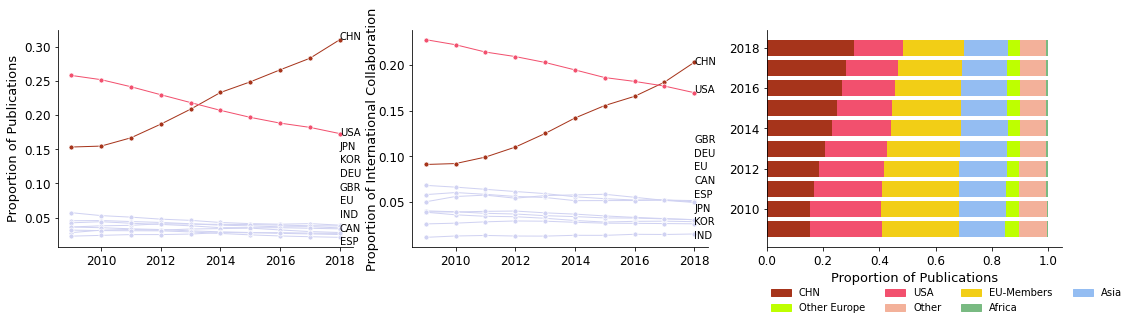

In [26]:
#{'#F2CB05':yellow,'#88C9F2':blue,'#C5C9C7':gray,'#F74F5A'}
years=[2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]

fig, ax=plt.subplots(nrows=1,ncols=3,figsize=(18,4))
ax0=ax[0]
ax1=ax[1]
ax2=ax[2]


texty=[0.31,0.17,0.15,0.13,0.11,0.09,0.07,0.05,0.03,0.01]
text=topn_df[topn_df.year==2018].sort_values(by='value',ascending=False)['Code'].values
plot(topn_df,ax0, texty, text)
ax0.set_xlabel("")
ax0.set_ylabel("Proportion of Publications",fontsize=13)
ax0.tick_params(axis='both', which='major', labelsize=12)

cntry_int=cntry_fund[cntry_fund.intcol==1]
topn_int=get_topn(cntry_int,topn)
texty=[0.20,0.17,0.115,0.1,0.085,0.07,0.055,0.04,0.025,0.01]
text=topn_int[topn_int.year==2018].sort_values(by='value',ascending=False)['Code'].values
plot(topn_int,ax1,texty,text)
ax1.set_xlabel("")
ax1.set_ylabel("Proportion of International Collaboration",fontsize=13,labelpad=0)
ax1.tick_params(axis='both', which='major', labelsize=12)

chn = regfund.loc[years,'China'].values
usa = regfund.loc[years,'USA'].values
eu = regfund.loc[years,'EU-Members'].values
asia = regfund.loc[years,'Asia'].values
africa = regfund.loc[years,'Africa'].values
othereu = regfund.loc[years,'Other Europe'].values
other = regfund.loc[years,'Other'].values
ax2.barh(years, chn,label='CHN',color='#A6341B')
ax2.barh(years,usa,label='USA',left = chn,color='#F2506E')
ax2.barh(years,eu,label='EU',left=chn+usa,color='#F2CE16')
ax2.barh(years,asia,label='Asia',left=chn+usa+eu,color='#94BDF2')
ax2.barh(years,othereu,label='Europe',left=chn+usa+eu+asia,color='#BEFF00')
ax2.barh(years,other,label='Other',left=chn+usa+eu+asia+othereu,color='#F3B19A')
ax2.barh(years,africa,label='Africa',left=chn+usa+eu+asia+othereu+other,color='#79BA82')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
legend=[Patch(label='CHN',color='#A6341B'),
        Patch(label='Other Europe',color='#BEFF00'),
       Patch(label='USA',color='#F2506E'),
        Patch(label='Other',color='#F3B19A'),
       Patch(label='EU-Members',color='#F2CE16'),
        Patch(label='Africa',color='#79BA82'),
       Patch(label='Asia',color='#94BDF2')]
ax2.set_xlabel("Proportion of Publications",fontsize=13)

ax2.legend(handles=legend,ncol=4,loc=(0,-0.32),frameon=False)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(cntry_funding_path,bbox_inches='tight')

In [41]:
topn_df.groupby(['year'])['value'].sum()

year
2009    0.710344
2010    0.707880
2011    0.704799
2012    0.707234
2013    0.710307
2014    0.714227
2015    0.713822
2016    0.714504
2017    0.719651
2018    0.728931
Name: value, dtype: float64

In [33]:
def gini_coef(alist):
    """ Gini Coefficient """
    cum_x = np.cumsum(sorted(np.append(alist, 0)))
    sum_x = cum_x[-1]
    xarray = np.array(range(0, len(cum_x))) / np.float64(len(cum_x) - 1)
    yarray = cum_x / sum_x
    B = np.trapz(yarray, x=xarray)
    A = 0.5 - B
    return A / (A + B)

In [27]:
cntry_ann=cntry_fund.groupby(['year','fund_cntry'])['cnt_frac'].sum().reset_index(name='count')

In [30]:
cntry_ann.head()

,year,fund_cntry,count
0,2009,Algeria,83.283333
1,2009,Andorra,2.000000
2,2009,Angola,0.500000
3,2009,Argentina,2702.798107
4,2009,Armenia,43.924242


In [35]:
df

,year,gini
0,2009,0.895353
1,2010,0.896452
2,2011,0.896325
3,2012,0.899685
4,2013,0.902530
5,2014,0.904669
6,2015,0.906125
7,2016,0.905272
8,2017,0.908157
9,2018,0.911122


In [34]:
resultlist=[]
for year in years:
    v=cntry_ann[cntry_ann.year==year]['count'].values
    gini=gini_coef(v)
    resultlist.append([year,gini])
df=pd.DataFrame(resultlist,columns=['year','gini'])

## archive code 

In [26]:
#R&D data
rd_df=pd.read_csv(rd_path)
rd_df = rd_df[rd_df.time.between(2009,2018)]
year_cntry_rd = rd_df.pivot_table(index='time',columns='WoS',values='value',fill_value=0)
year_cntry_rd = year_cntry_rd.div(year_cntry_rd.sum(axis=1), axis=0).reset_index()
year_cntry_rd = year_cntry_rd.melt(id_vars='time',value_name='ratio')
yearlist=np.arange(2009,2019)
def get_topn_ratio(data_df,timecol,valuecol,cntry_col):
    result=[]
    for year in yearlist:
        data_filter=data_df[data_df[timecol]==year]
        total=data_filter[valuecol].sum()
        top2=data_filter[data_filter[cntry_col].isin(['China','United States'])][valuecol].sum()/total
        topr=data_filter[data_filter[cntry_col].isin(topn)][valuecol].sum()/total
        result.append([year,top2,topr])
    return result
top_rd=get_topn_ratio(rd_df,'time','value','WoS')
top_rd=pd.DataFrame(top_rd,columns=['year','top2_rd','topn_rd'])
top_rd.head()

,year,top2_rd,topn_rd
0,2009,0.482378,0.776628
1,2010,0.479027,0.768448
2,2011,0.482435,0.769987
3,2012,0.491073,0.775459
4,2013,0.497585,0.775757


In [28]:
cntry_fund_frac=cntry_fund.groupby(['fund_cntry','year'])['cnt_frac'].sum().reset_index()
top_fund=get_topn_ratio(cntry_fund_frac,'year','cnt_frac','fund_cntry')
top_fund_df=pd.DataFrame(top_fund,columns=['year','top2_pub','topn_pub'])
top_meta=top_fund_df.merge(top_rd,on=['year'])
top_meta.head()

,year,top2_pub,topn_pub,top2_rd,topn_rd
0,2009,0.410961,0.710344,0.482378,0.776628
1,2010,0.406117,0.707880,0.479027,0.768448
2,2011,0.407931,0.704799,0.482435,0.769987
3,2012,0.416210,0.707234,0.491073,0.775459
4,2013,0.426645,0.710307,0.497585,0.775757


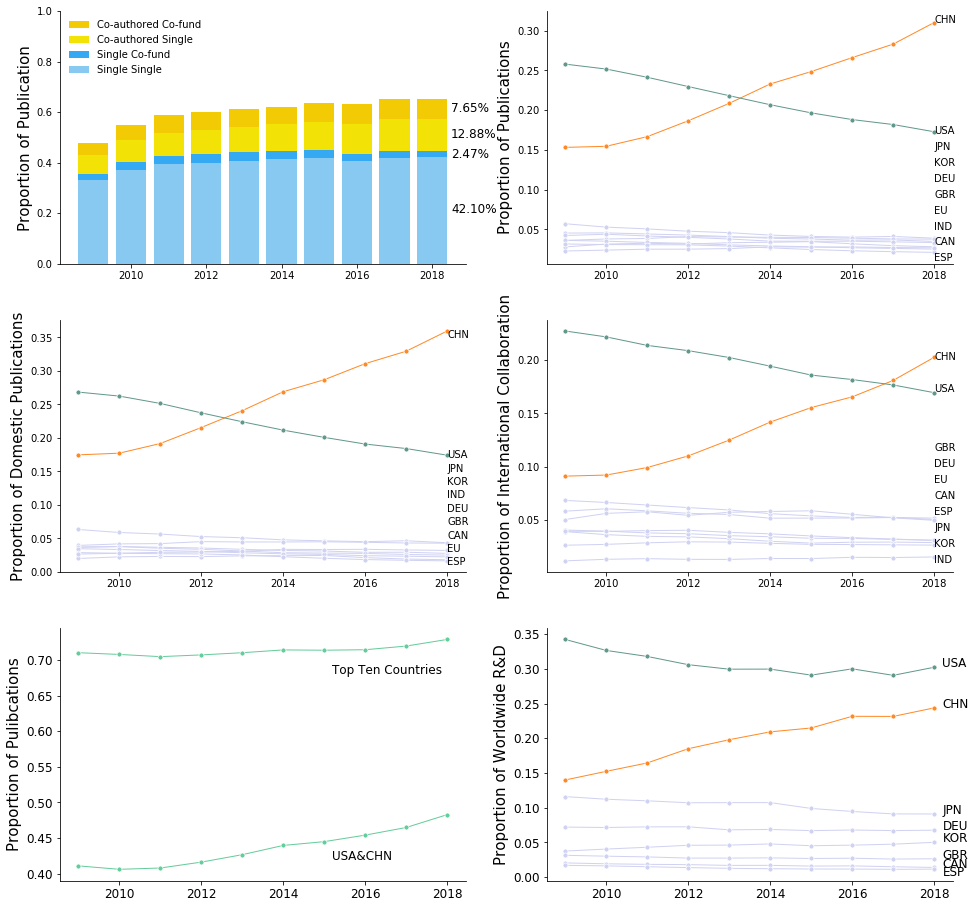

In [67]:
fig, ax=plt.subplots(nrows=3,ncols=2,figsize=(16,16))

plt.subplots_adjust(hspace=0.22,wspace=0.2)
sn=type_cnt['s-n'].values
ss=type_cnt['s-s'].values
sc=type_cnt['s-c'].values
cs=type_cnt['c-s'].values
cc=type_cnt['c-c'].values
cn=type_cnt['c-n'].values
labels=np.arange(2009,2019,1)

ax[0][0].bar(labels,ss, label='Single Single',color='#88C9F2')
ax[0][0].bar(labels,sc, bottom=ss,label='Single Co-fund',color='#35AAF2')
ax[0][0].bar(labels,cs, bottom=ss+sc,label='Co-authored Single',color='#F2E205')
ax[0][0].bar(labels,cc, bottom=ss+sc+cs,label='Co-authored Co-fund',color='#F2CB05')

ax[0][0].set_xticks(np.arange(2010,2019,2))
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['top'].set_visible(False)
ax[0][0].set_yticks(np.arange(0,11,2)/10)
ax[0][0].set_ylabel("Proportion of Publication",fontsize=15)
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles[::-1], labels[::-1],loc=2,frameon=False)
ax[0][0].text(2018.5,0.2,s="{:.2%}".format(ss[-1]),fontsize=12)
ax[0][0].text(2018.5,0.42,s="{:.2%}".format(sc[-1]),fontsize=12)
ax[0][0].text(2018.5,0.5,s="{:.2%}".format(cs[-1]),fontsize=12)
ax[0][0].text(2018.5,0.6,s="{:.2%}".format(cc[-1]),fontsize=12)


cntry_ratio=cal_ratio(cntry_fund_frac_df)
topn_df=get_topn(cntry_ratio,topn)
texty=[0.31,0.17,0.15,0.13,0.11,0.09,0.07,0.05,0.03,0.01]
text=topn_df[topn_df.year==2018].sort_values(by='value',ascending=False)['Code'].values
plot(topn_df,ax[0][1], texty, text)
custom_lines=[Line2D([0], [0], color=c) for c in clist]
#ax[1][1].legend(custom_lines,topn,loc=(1.1,0.2),fontsize='medium',frameon=False)
ax[0][1].set_xlabel("")
ax[0][1].set_ylabel("Proportion of Publications",fontsize=15)
#ax[0][1].arrow(2017.5,0.13,-2,-0.08,head_width=0.01)


cntry_domes=cntry_fund_frac_df[cntry_fund_frac_df.intcol==0]
cntry_domes_ratio=cal_ratio(cntry_domes)
topn_domes=get_topn(cntry_domes_ratio,topn)
texty=[0.35,0.17,0.15,0.13,0.11,0.09,0.07,0.05,0.03,0.01]
text=topn_domes[topn_domes.year==2018].sort_values(by='value',ascending=False)['Code'].values
plot(topn_domes,ax[1][0],texty,text)
ax[1][0].set_xlabel("")
ax[1][0].set_ylabel("Proportion of Domestic Publications",fontsize=15)

cntry_int=cntry_fund_frac_df[cntry_fund_frac_df.intcol==1]
cntry_int_ratio=cal_ratio(cntry_int)
topn_int=get_topn(cntry_int_ratio,topn)
texty=[0.20,0.17,0.115,0.1,0.085,0.07,0.055,0.04,0.025,0.01]
text=topn_int[topn_int.year==2018].sort_values(by='value',ascending=False)['Code'].values
plot(topn_int,ax[1][1],texty,text)
ax[1][1].set_xlabel("")
ax[1][1].set_ylabel("Proportion of International Collaboration",fontsize=15)

xlabels=np.arange(2008,2019,2)
sns.lineplot(x='year',y='top2_pub',data=top_meta,ax=ax[2][0],color='#65CC9B',legend=False,dashes=True,marker='o',linewidth=1,markersize=5)
sns.lineplot(x='year',y='topn_pub',data=top_meta,ax=ax[2][0],color='#65CC9B',legend=False,dashes=True,marker='o',linewidth=1,markersize=5)
ax[2][0].spines['right'].set_visible(False)
ax[2][0].spines['top'].set_visible(False)
ax[2][0].text(2015.2,0.42,'USA&CHN',fontsize=12)
ax[2][0].text(2015.2,0.68,'Top Ten Countries',fontsize=12)
ax[2][0].set_xticklabels(xlabels,fontsize=12)
ax[2][0].tick_params(axis='y', labelsize=12)
ax[2][0].set_ylabel("Proportion of Pulibcations",fontsize=15)
ax[2][0].set_xlabel("")


year_cntry_rd_sub=year_cntry_rd[year_cntry_rd.WoS.isin(topn)]
year_cntry_rd_sub=year_cntry_rd_sub.merge(flag_df,on='WoS')
text_pos=dict(zip(year_cntry_rd_sub.Code.values,np.round(year_cntry_rd_sub.ratio.values,4)))
text_pos['ESP']=0.002
sns.lineplot(x='time',y='ratio',hue='WoS',data=year_cntry_rd_sub,hue_order=topn,ax=ax[2][1],legend=False,palette=clist,marker='o',linewidth=1,markersize=5)
ax[2][1].spines['right'].set_visible(False)
ax[2][1].spines['top'].set_visible(False)
for s,y in text_pos.items():
    ax[2][1].text(2018.2,y,s,fontsize=12)
ax[2][1].set_xticklabels(xlabels,fontsize=12)
ax[2][1].tick_params(axis='y', labelsize=12)
ax[2][1].set_ylabel("Proportion of Worldwide R&D",fontsize=15)
ax[2][1].set_xlabel("")


plt.savefig(global_funding_path,bbox_inches='tight')